# Cleaning the ocean

Did you know that over 8 million tons of plastic are dumped into the oceans each year? Addressing this environmental challenge requires prevention and an efficient marine waste collection strategies. By applying the Vehicle Routing Problem (VRP) to this issue, we hope to optimize the routes of vessels involved in the cleanup, ensuring the most effective removal of waste while conserving time and resources.


### Librairies

Some useful libraries that we are going to use :

In [1]:
import cudaq
from cudaq import spin
import itertools
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.applications import Maxcut, Tsp
from typing import List
from utils.tsp import brute_force_tsp
from utils.graph import generate_point_graph_with_weights, draw_graph
from mpi4py import MPI

cudaq.set_target('qpp-cpu') # Comment this to run on GPU

np.random.seed(42)
cudaq.set_random_seed(42)

In [2]:
# Define MPI communication for distributed computing
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

## Problem definition

### Parameters

In [3]:
number_of_garbage = 12
max_weight_per_boat = 300

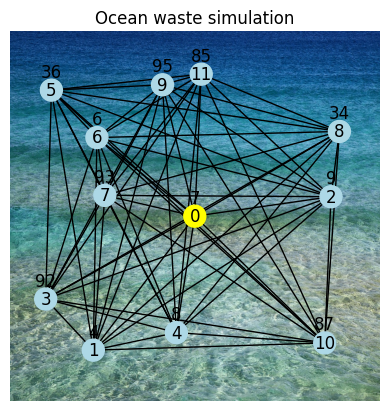

In [5]:
if rank == 0:
    garbage_graph = generate_point_graph_with_weights(number_of_garbage)
    draw_graph(garbage_graph)

## Clustering

Although this seems like an easy problem, it scales very poorly. In fact, with only 15 sites, there are 43 billion possible routes. The problem becomes even worse when you add multiple boats, as the Vehicle Routing Problem (VRP) suggests. Even though this problem may seem insurmountable, we can use various heuristics to help us find reasonably good solutions.

One such solution is to divide the graph that was created using clustering. Once clustered, each part of the problem becomes simpler. An easy way to cluster the problem is by boat. Since each boat will be going in a specific direction, it makes sense for them to cover most of the nearest points.

Each boat has a transport capacity. The problem then more closely resembles the Capacitated Vehicle Routing Problem (CVRP).

In [20]:

def CC(cluster):
    pos = nx.get_node_attributes(cluster, 'pos')
    vi_x = [pos[node][0] for node in cluster.nodes()]
    vi_y = [pos[node][1] for node in cluster.nodes()]
    n = len(vi_x)
    x = np.sum(vi_x)/n
    y = np.sum(vi_y)/n
    return x,y

if rank == 0:
    sum_weight = sum(data['weight'] for node, data in garbage_graph.nodes(data=True))
    max_weight = max(data['weight'] for node, data in garbage_graph.nodes(data=True))
    
    number_of_boat = np.ceil(sum_weight/max_weight_per_boat) + 1
    
    local_graph = []
    
    for i in range(number_of_boat):
        local_graph
        while w < C:
            i += 1
            centroid = CC(Cluster)
            distances_new = np.linalg.norm(np.subtract(positions_list, list(centroid)), axis=1)
            min_new = np.partition(distances_new, i)[i]
            min_new_index = np.where(distances_new == min_new)[0][0]
            min_new_position = positions_list[min_new_index]
            Cluster.add_node(i, pos=min_new_position, weight=[weights[node] for node, position in positions.items() if position == min_new_position])
            w += Cluster.nodes[i]['weight'][0]
        Cluster.remove_node(max(Cluster.nodes()))
    
    

556


In [4]:
# Scatter everything
if rank == 0:
    graph_list = [garbage_graph]
    chunks = [graph_list[i::size] for i in range(size)]
else:
    chunks = None

my_chunk = comm.scatter(chunks, root=0)

## TSP & QUBO matrix

### QUBO to Maxcut

### TSP Definition

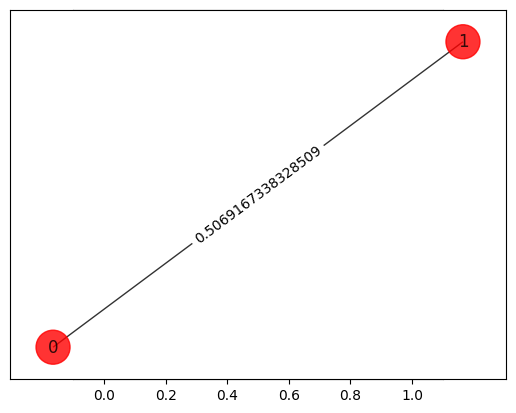

In [5]:
if rank == 0:
    adj_matrix = nx.to_numpy_array(garbage_graph)

    draw_graph(garbage_graph)

### TSP Classical

Best order from brute force = (0, 1) with total distance = 1.0138334676657017


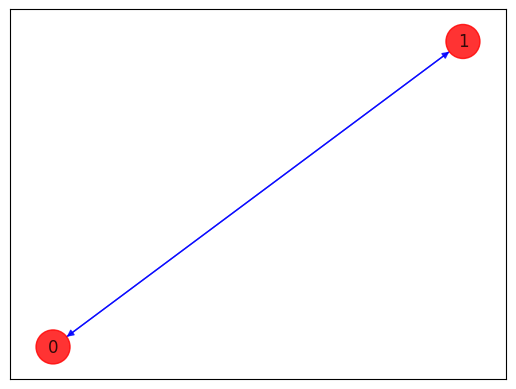

In [6]:
best_distance, best_order = brute_force_tsp(adj_matrix, number_of_garbage)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")


draw_tsp_solution(garbage_graph, best_order, colors, pos)


### TSP Nvidia

In [7]:

tsp = Tsp(garbage_graph)

qp = tsp.to_quadratic_program()

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

In [8]:
coeffs = qubitOp.coeffs

hamiltonian = 0

for i in range(len(qubitOp.paulis)):
    only_one = True
    # find position of first Z
    #print(str(qubitOp.paulis[i]))
    pauli_string = str(qubitOp[i].to_list()[0][0])
    x = pauli_string.index("Z")
    y = x
    # check if their is another Z
    if pauli_string.count("Z") > 1:
        only_one = False
        y = pauli_string.index("Z", x + 1)

    if only_one:
        hamiltonian += coeffs[i] * spin.z(y)
    else:
        hamiltonian += coeffs[i] * spin.z(x) * spin.z(y)


In [9]:
# Problem parameters.
qubit_count: int = number_of_garbage ** 2
layer_count: int = 2
parameter_count: int = 2 * layer_count


@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float]):
    """QAOA ansatz for Max-Cut"""
    qvector = cudaq.qvector(qubit_count)

    # Create superposition
    h(qvector)

    # Loop over the layers
    for layer in range(layer_count):
        # Loop over the qubits
        # Problem unitary
        for qubit in range(qubit_count):
            x.ctrl(qvector[qubit], qvector[(qubit + 1) % qubit_count])
            rz(2.0 * thetas[layer], qvector[(qubit + 1) % qubit_count])
            x.ctrl(qvector[qubit], qvector[(qubit + 1) % qubit_count])

        # Mixer unitary
        for qubit in range(qubit_count):
            rx(2.0 * thetas[layer + layer_count], qvector[qubit])


# Specify the optimizer and its initial parameters. Make it repeatable.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)


# Define the objective, return `<state(params) | H | state(params)>`
def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         parameters).expectation()


# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, optimal_parameters)

Initial parameters =  [0.07606593617592367, -0.04254285642508521, -0.3141789664294502, -0.03200584540641893]
Optimal value =  -1.513833158430663
Optimal parameters =  [0.3928533398894903, 0.1963057493961611, -0.7850329684914422, -2.3566747887983928]


In [10]:
results = {}
for i, key in counts.items():
    results[i] = key
if rank == 0:
    plot_histogram(results)

In [11]:
if rank == 0:
    # Find the maximum frequency
    max_frequency = max(results.values())

    # Find the top 5 most frequent binary strings
    sorted_results = sorted(results.items(), key=lambda item: item[1], reverse=True)
    top_five = sorted_results[:4]

    # Print the results
    print("Top 4 most frequent binary strings:")
    for binary_string, frequency in top_five:
        print(f"Binary string: {binary_string}, Frequency: {frequency}")

Top 4 most frequent binary strings:
Binary string: 0110, Frequency: 137
Binary string: 1001, Frequency: 123
Binary string: 0011, Frequency: 115
Binary string: 1100, Frequency: 113


In [13]:
all_results = comm.gather(sorted_results, root=0)

if rank == 0:
    # Plot all result
    for result in all_results:
        best_result = result[0]
        print(best_result)

('0110', 137)


## Bibliography


https://www.sciencedirect.com/topics/earth-and-planetary-sciences/traveling-salesman-problem#:~:text=With%2C%20say%2C%20n%20%3D%2015,to%20the%20traveling%20salesman%20problem.